# Stock market analysis during the Covid-19 pandemic

#### Summary:
The Covid-19 pandemic had severe impacts on stock markets. It would be informative to identify the trends of a chosen industry and validate the claims/forecasts of different analysts and agencies. Through public data from yahoo finance, stock market data can be obtained to identify these trends. Also, through qualitative research on various agencies such as Morningstar, their claims can be validated with data. An overall stock price trend report of a chosen industry can be used as a general guide for future pandemics and financial crises.

## Libraries

In [509]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
import yfinance as yf

## Validate analyst claims 

### Morningstar
Ali Mogharabi from Morningstar: 'both companies (Uber and Lyft) will recover from this, although it will take until next year.’

Prediction: Recovery will take until 2021, where recovery is taken to be pre-covid levels (defined as highest price of stock between Jan-Feb 2020 which was just before Covid-19)

In [459]:
#Markets open on 2nd Jan as 1st Jan is public holiday
#Time horizon from Jan 2020 - Apr 2021
data = yf.download("UBER LYFT", start="2020-01-02", end="2021-04-30", interval="1d", group_by="ticker")
data = data.reset_index() #to convert date from index to column 

[*********************100%***********************]  2 of 2 completed


In [460]:
data.head()

Date       UBER                                                        \
                   Open       High        Low      Close  Adj Close    Volume   
0 2020-01-02  29.940001  31.000000  29.790001  30.990000  30.990000  20578900   
1 2020-01-03  30.620001  31.430000  30.480000  31.370001  31.370001  18822700   
2 2020-01-06  31.010000  32.060001  31.000000  31.580000  31.580000  21204700   
3 2020-01-07  31.790001  32.840000  31.360001  32.810001  32.810001  30119600   
4 2020-01-08  32.730000  34.520000  32.459999  33.930000  33.930000  43944400   

        LYFT                                                       
        Open       High        Low      Close  Adj Close   Volume  
0  43.220001  44.070000  43.165001  43.580002  43.580002  3912100  
1  42.849998  43.360001  42.233002  43.189999  43.189999  4407200  
2  42.790001  43.810001  42.380001  43.099998  43.099998  4964600  
3  43.180000  44.700001  43.029999  44.250000  44.250000  4773500  
4  44.139999  45.740002  43.869999  45.080002  45.080002  5636300

In [465]:
#empty dataframe to store results
col = ['Stock', 'Pre-Covid level', 'Earliest recovery date', 'Price']
recover_df = pd.DataFrame(columns = col)

#function that takes in stock ticker symbol and returns pre covid stock price which is defined as the highest price of the stock
#between Jan-Feb 2020, the earliest date that the stock hits or surpasses pre-covid level and the price. 
def recover(stock):
    data = yf.download(stock, start="2020-01-02", end="2021-04-30", interval="1d")
    data = data.reset_index()
    index = int(data[data['Date'] == '2020-02-28'].index.values) #index for last date of trading in feb 2020
    pre_covid = round(max(data['Close'].iloc[:index]),2)
    for i in range(index+1,len(data)):
        if data['Close'].iloc[i]>= pre_covid:
            date = data['Date'].iloc[i].date()
            price = round(data['Close'].iloc[i],2)
            break
    try:
        df = pd.Series([stock,pre_covid,date,price],index = col)
    except:
        price = round(max(data['Close'].iloc[index+1:]),2)
        date = data['Date'].iloc[int(data[data['Close']==max(data['Close'].iloc[index+1:])].index.values)].date()
        df = pd.Series([stock,pre_covid,date,price],index = col)
    global recover_df
    recover_df = recover_df.append(df, ignore_index = True)
    
for i in ['UBER', 'LYFT']:
    recover(i)
recover_df




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Stock,Pre-Covid level,Earliest recovery date,Price
0,UBER,41.27,2020-11-05,41.96
1,LYFT,53.94,2021-02-10,56.21


Prediction that recovery will take until 2021 is partially true. Actual recovery was quicker for Uber that occurred on 5 Nov 2020, but actual recovery was as predicted for Lyft that occurred on 10 Feb 2021 when stock prices recovered to pre-covid levels.

## Fair value estimate
Morningstar provides fair value estimates for stocks which are like reference points that an investor can use to determine if a stock is undervalued or overvalued. 

In [188]:
#empty dataframe to store results
col = ['Stock', 'Current date', 'Current price', 'Fair value estimate', 'Actual price', 'Time to reach fair/max/min value', 
       'Profit','Hit fair value?']
fairvalue_df = pd.DataFrame(columns = col)

#function that takes in the stock ticker symbol, fair value estimate, date of analysis,
#and returns when the fair value estimate is achieved, the profit earned from buying the stock when price < fair value, 
#and if price increases further when price > fair value 
def fairvalue(stock, estimate, date):
    data = yf.download(stock, start="2020-01-02", end="2021-04-30", interval="1d")
    data = data.reset_index()
    index = data[data['Date'] == date].index.values
    price = np.round(data['Close'].iloc[index].values[0],2)
    if price < estimate: # buy since price < fair value
        if max(data['Close'].iloc[int(index):]) < estimate: # did not hit fair value
            actualprice = round(max(data['Close'].iloc[int(index):]),2)
            maxprice = data[data['Close'] == max(data['Close'].iloc[int(index):])].index.values
            time = [data['Date'].iloc[int(maxprice)].date(), data['Date'].iloc[int(maxprice)] - pd.to_datetime(date) ]
            profit = "{:.0%}".format((actualprice-price)/price)
        else: # hit fair value
            for i in range(int(index),len(data)):
                if data['Close'][i] >= estimate:
                    actualprice = round(data['Close'].iloc[i],2)
                    time = [data['Date'].iloc[i].date(),data['Date'].iloc[i]-pd.to_datetime(date)]
                    profit = "{:.0%}".format((actualprice-price)/price)
                    break
        if actualprice < estimate:
            hit = 'No'
        else:
            hit = 'Yes'
    else: # sell since price > fair value
        for i in range(int(index),len(data)):
            if data['Close'][i] <= estimate: # hit fair value
                actualprice = round(data['Close'][i],2)
                time = [data['Date'][i].date(),data['Date'][i]-pd.to_datetime(date)]
                profit = "{:.0%}".format((price - actualprice)/actualprice)
                break
            else: # did not hit fair value
                actualprice = round(min(data['Close'].iloc[int(index):]),2)
                minprice = data[data['Close'] == min(data['Close'].iloc[int(index):])].index.values
                time = [data['Date'].iloc[int(minprice)].date(), data['Date'].iloc[int(minprice)] - pd.to_datetime(date) ]
                profit = "{:.0%}".format((price - actualprice)/actualprice)
                break
        if actualprice <= estimate:
            hit = 'Yes'
        else:
            hit = 'No'
    df = pd.Series([stock,date,'$'+str(price),'$'+str(estimate),'$'+str(actualprice),time,profit,hit], index = col)
    global fairvalue_df
    fairvalue_df = fairvalue_df.append(df, ignore_index = True)
    
    
    
    

In [247]:
#analysis from https://www.morningstar.com/articles/972772/5-stocks-we-like
#buy as fair value > current price
stocks = ['FANG', 'FSLR', 'SYY', 'CMCSA']
date = '2020-03-17'
fair_value = [90,59,59,49]
#function that takes in stock ticker, date, fair value and returns output of fairvalue function defined above
def morningstar(stocks, date, fair_value):
    stock_dict = {'stocks': stocks, 'date': date, 'fair_value': fair_value}
    for i in range(len(stock_dict['stocks'])):
        stock = stock_dict['stocks'][i]
        estimate = stock_dict['fair_value'][i]
        fairvalue(stock,estimate,date)
morningstar(stocks,date,fair_value)

#analysis from https://www.morningstar.com/articles/973345/5-more-stocks-we-like
#buy as fair value > current price
stocks = ['CVE','BUD','CTVA','AXP','ECL']
date = '2020-03-19'
fair_value = [7,96,40,125,191]
morningstar(stocks, date, fair_value)

#analysis from https://www.morningstar.com/articles/976067/6-more-stocks-we-like (stock name 'CTL' changed to 'LUMN')
#buy as fair value > current price
stocks = ['CLR', 'LUMN', 'VVV', 'INGR', 'TWNK', 'GOOG']
date = '2020-04-02'
fair_value = [19,18,19.8,125,15.8,1400]
stock_dict = {'stocks':['CLR', 'LUMN', 'VVV', 'INGR', 'TWNK', 'GOOG'], 'date':'2020-04-02', 
              'fair_value':[19,18,19.8,125,15.8,1400]}
morningstar(stocks, date, fair_value)

#analysis from https://www.morningstar.com/articles/999855/3-expensive-diy-stocks-to-watch
# sell as fair value < current price
stocks = ['HD', 'LOW', 'SHW']
date = '2020-08-28'
fair_value = [200, 133, 360]
stock_dict = {'stocks':['HD', 'LOW', 'SHW'], 'date':'2020-08-28', 'fair_value':[200, 133, 360]}
morningstar(stocks, date, fair_value)

fairvalue_df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Stock,Current date,Current price,Fair value estimate,Actual price,Time to reach fair/max/min value,Profit,Hit fair value?
0,FANG,2020-03-17,$20.23,$90,$85.27,"[2021-03-05, 353 days 00:00:00]",322%,No
1,FSLR,2020-03-17,$32.26,$59,$61.78,"[2020-07-14, 119 days 00:00:00]",92%,Yes
2,SYY,2020-03-17,$35.06,$59,$59.1,"[2020-06-03, 78 days 00:00:00]",69%,Yes
3,CMCSA,2020-03-17,$38.22,$49,$49.0,"[2020-11-13, 241 days 00:00:00]",28%,Yes
4,CVE,2020-03-19,$1.64,$7,$7.19,"[2021-02-22, 340 days 00:00:00]",338%,Yes


In [384]:
fairvalue('HD', 200, '2020-08-27' )

[*********************100%***********************]  1 of 1 completed
HD
current date: 2020-08-27
current price: $288.63
fair value estimate: $200
Highest price: $328.08 on 2021-04-16 00:00:00
lowest price did not hit fair value: $250.93 on 2021-03-04 00:00:00


## yfinance recommendations - review of IT sector
The package yfinance allows users to download historical market data from yahoo finance. It also provides recommendations which will be validated. 

In [276]:
#function for data cleaning. Takes in ticker symbol as input and outputs data from Jan 2020 - Apr 2021
def clean(stock):
    stock_df = yf.Ticker(stock)
    stock_df = stock_df.recommendations.reset_index()
    stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date #get rid of the time and keep the date portion 
    for i in range(len(stock_df)):
        if stock_df['Date'][i].year==2020:
            index_1 = i 
            break
    for k in range(len(stock_df)):
        if stock_df['Date'][k].year==2021 and stock_df['Date'][k].month==5:
            index_2 = k
            break
    try:
        stock_df = stock_df.iloc[index_1:index_2]
    except: # error due to no recommendations in May 2021, so take last recommendation
        stock_df = stock_df.iloc[index_1:]
    return stock_df


In [233]:
#Example from Uber
uber_df = clean('UBER')
uber_df.head()

,Date,Firm,To Grade,From Grade,Action
47,2020-01-10,Bernstein,Outperform,,init
48,2020-01-23,Guggenheim,Buy,,main
49,2020-01-28,UBS,Buy,,init
50,2020-01-31,JP Morgan,Overweight,,init
51,2020-02-03,Wedbush,Outperform,,main


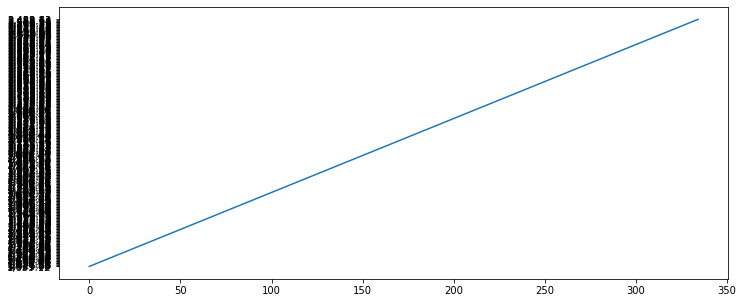

In [410]:
#import S&P 500 Information Technology (S5INFT) historical data as yfinance does not include it, from 
#https://www.investing.com/indices/s-p-500-information-technology-historical-data
S5INFT = pd.read_csv('S&P 500 Information Technology Historical Data.csv')
S5INFT['Date'] = pd.to_datetime(S5INFT['Date'])
S5INFT = S5INFT.iloc[::-1]
S5INFT = S5INFT.reset_index().drop('index',axis=1)
#plot graph
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.plot('Price',data = S5INFT)
#ax.xaxis_date()
#plt.xticks(np.arange(0,len(S5INFT['Date'])+1,1))
#plt.yticks(np.arange(0,len(S5INFT['Price'])+1,20))
#figure(figsize=(640, 480), dpi=200)
plt.show()

In [314]:
#Top 30 companies in terms of market cap from the S&P 500 Information Technology. It comprises the companies (75 constituents) 
#included in the S&P 500 that are classified as members of the GICS information technology sector.
#Data taken as of May 2021 from https://www.tradingview.com/symbols/SP-S5INFT/components/

itlist = ['AAPL','MSFT','V','NVDA','MA','PYPL','ADBE','INTC', 'ORCL','CSCO','CRM','ACN','AVGO','TXN','QCOM','IBM','AMAT','INTU',
         'AMD','NOW','FIS','MU','LRCX','ADP','FISV','ADSK','ADI','GPN','NXPI','KLAC']
itdict = {}
for i in itlist:
    itdict[i] = clean(i)

In [294]:
#get all the unique recommendations from 'To Grade' column
unique_list_1 = []
for i in itdict:
    unique_list_1.append(itdict[i]['To Grade'].unique())
unique_list_2 = []
for i in range(len(unique_list_1)):
    for k in unique_list_1[i]:
        unique_list_2.append(k)
unique_list_3 = pd.Series(unique_list_2).unique()
unique_list_3

array(['Outperform', 'Buy', 'Underweight', 'Overweight', 'Neutral',
       'Hold', 'Equal-Weight', 'Underperform', 'Market Perform', 'Sell',
       'Sector Perform', 'Strong Buy', 'Positive', 'Sector Weight',
       'Perform', 'Reduce', 'Market Outperform', 'In-Line',
       'Peer Perform', 'Top Pick'], dtype=object)

In [311]:
# 3 categories - buy, neutral, sell 
buy_list = ['Outperform','Buy','Overweight','Strong Buy','Positive','Market Outperform','Top Pick',]
neutral_list = ['Neutral','Hold','Equal-Weight','Market Perform','Sector Perform', 'Sector Weight','Perform','In-Line',
               'Peer Perform']
sell_list = ['Underweight','Underperform','Sell','Reduce']

# Total number of recommendations for each category 
buy_counter = 0
neutral_counter = 0
sell_counter = 0
for i in itdict:
    for k in range(len(itdict[i]['To Grade'])):
        if itdict[i]['To Grade'].iloc[k] in buy_list:
            buy_counter += 1
        elif itdict[i]['To Grade'].iloc[k] in neutral_list:
            neutral_counter += 1
        elif itdict[i]['To Grade'].iloc[k] in sell_list:
            sell_counter += 1 
print('buy: ' + str(buy_counter), 'neutral: ' + str(neutral_counter), 'sell: ' + str(sell_counter))

#dates of neutral/sell recommendations 
selltime = []
for i in itdict:
    for k in range(len(itdict[i]['To Grade'])):
        if itdict[i]['To Grade'].iloc[k] in neutral_list or itdict[i]['To Grade'].iloc[k] in sell_list :
            selltime.append(itdict[i]['Date'].iloc[k])
month_dict = {}
for i in range(len(selltime)):
    month = selltime[i].month
    year = selltime[i].year
    date = month,year
    if date not in month_dict:
        month_dict[date] = 0
    else:
        month_dict[date] += 1

month_dict
# neutral/sell recommendations are spread out throughout the year 

buy: 1489 neutral: 431 sell: 63


{(1, 2020): 57,
 (3, 2020): 44,
 (4, 2020): 55,
 (6, 2020): 26,
 (7, 2020): 41,
 (8, 2020): 18,
 (9, 2020): 37,
 (10, 2020): 28,
 (1, 2021): 34,
 (4, 2021): 25,
 (5, 2020): 34,
 (2, 2020): 25,
 (2, 2021): 22,
 (12, 2020): 13,
 (11, 2020): 8,
 (3, 2021): 11}

In [449]:
#which firm had the most neutral/sell recommendations?
col = ['Stock', 'Number of buy recommendations', 'Number of neutral recommendations', 'Number of sell recommendations']
firm_df = pd.DataFrame(columns = col)
for i in itdict:
    stock = i
    buy_count = 0
    neutral_count = 0
    sell_count = 0
    for k in range(len(itdict[i]['To Grade'])):
        if itdict[i]['To Grade'].iloc[k] in buy_list:
            buy_count+=1
        elif itdict[i]['To Grade'].iloc[k] in neutral_list:
            neutral_count+=1
        elif itdict[i]['To Grade'].iloc[k] in sell_list:
            sell_count+=1
    df = pd.Series([stock,buy_count,neutral_count,sell_count], index = col)
    firm_df = firm_df.append(df, ignore_index = True)
firm_df['buy:neutral+sell'] = firm_df['Number of buy recommendations']/(firm_df['Number of neutral recommendations'] + 
                                                                        firm_df['Number of sell recommendations'])


In [547]:
firm_df.head()

,Stock,Number of buy recommendations,Number of neutral recommendations,Number of sell recommendations,buy:neutral+sell
0,AAPL,153,36,5,3.73171
1,MSFT,85,4,0,21.25
2,V,67,6,0,11.1667
3,NVDA,103,8,2,10.3
4,MA,68,6,0,11.3333


In [467]:
#firms with more neutral and sell recommendations than buy recommendations 
firm_negative = []
for i in range(len(firm_df['Stock'])):
    if firm_df['buy:neutral+sell'].iloc[i]<1:
        firm_negative.append(firm_df['Stock'].iloc[i])
firm_negative

['INTC', 'ORCL', 'CSCO', 'TXN', 'IBM', 'ADP', 'KLAC']

In [472]:
recover_df = pd.DataFrame(columns = col)
for i in firm_df['Stock']:
    recover(i)
recover_df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Stock,Pre-Covid level,Earliest recovery date,Price
0,AAPL,81.80,2020-06-05,82.88
1,MSFT,188.70,2020-06-09,189.80
2,V,213.31,2020-08-28,215.71
3,NVDA,314.70,2020-05-11,322.62
4,MA,344.56,2020-08-25,347.66


In [480]:
negative_df = pd.DataFrame(columns = col)
for i in firm_negative:
    #print(type(recover_df.iloc[int(recover_df[recover_df['Stock']==i].index.values)])
    #df = pd.Series(recover_df.iloc[int(recover_df[recover_df['Stock']==i].index.values)])
    negative_df = negative_df.append(recover_df.iloc[int(recover_df[recover_df['Stock']==i].index.values)], ignore_index = True)
negative_df
print('average recovery date: '+ str(recover_df['Earliest recovery date']))

,Stock,Pre-Covid level,Earliest recovery date,Price
0,INTC,68.47,2021-04-09,68.26
1,ORCL,55.73,2020-07-02,55.94
2,CSCO,49.93,2021-03-22,50.30
3,TXN,134.25,2020-07-20,136.58
4,IBM,156.76,2021-04-29,144.24
5,ADP,181.25,2021-03-09,183.06
6,KLAC,182.57,2020-06-03,186.05


In [546]:
#function that takes in a list of dates and returns the average date 
def avg(dates):
    any_reference_date = datetime.datetime(2020, 2, 28)
    return any_reference_date + (sum([date - any_reference_date for date in dates],datetime.timedelta()) / len(dates))
print('average date to reach pre-covid/max level: ' + str(avg(pd.to_datetime(recover_df['Earliest recovery date']))))
print('average date to reach pre-covid/max level for negative firms: ' + 
      str(avg(pd.to_datetime(negative_df['Earliest recovery date']))))
# negative firms which are those with more neutral/sell recommendations than buy recommendations take a longer time on average
# to recover to pre-covid levels or max price. 

average date to reach pre-covid/max level: 2020-08-29 01:36:00
average date to reach pre-covid/max level for negative firms: 2020-12-03 20:34:17.142857
